In [1]:
import numpy as np
from scipy.stats import bootstrap
import matplotlib.pyplot as plt

In [155]:
# subsample_indices = np.random.choice(len(dm), size=subsample_size, replace=False)
def my_bootstrap(data, bsfunction, fraction, num_samples):
    length = len(data[0])
    samples_indexes = np.random.choice(length, size=(num_samples, round(fraction * length)))
    
    res = np.array([bsfunction([data[0][samples_indexes[i,:]], data[1][samples_indexes[i,:]]]) for i in range(num_samples)])
    
    return res*1/fraction, (1/fraction)**2 * np.cov(res.T)

In [120]:
# create the plot directly from binning masses
def generate_rho_distrib_parts_cum(data):
    masses, distances = data[0], data[1]
    # print(masses)
    masses_cum = np.array([(np.sum(masses[distances < distance_bins[i]])) for i in range(1,
                  len(distance_bins))])
    
    return masses_cum #/ (4/3 * np.pi * distance_bins[1:]**3).to(u.m**3)

# create the plot directly from binning masses
def generate_rho_distrib_parts(data, distance_bins):
    masses, distances = data[0], data[1]    
    # array of distances of each particle to the host Galaxy centr    
    # All DM particles have the same mass:
    

    # create bins array
    # distance_bins = np.linspace(0,max_distance_kpc.value,num_bins+1,endpoint=True) * u.kpc

    res = np.histogram(distances, bins=distance_bins, weights=masses)
    N, R = res[0], res[1]
    R_inner, R_outer = R[0:-1], R[1:]

    m       = N

    V_outer = 4/3 * np.pi * R_outer**3
    V_inner = 4/3 * np.pi * R_inner**3

    rho       = m / (V_outer-V_inner)
    
    return rho

In [148]:
def covariance_matrix_degeneracy_demo(num_points, num_bins, distance_bins, samples, name):
    masses = np.random.rand(num_points) * 10
    distances = np.random.exponential(scale=1, size=num_points) * 20

    true_density = generate_rho_distrib_parts_cum([masses, distances])

    
    plt.figure(dpi=300)
    fig, axes = plt.subplots(1,2,figsize=(10,5), dpi=300)
    axes[0].scatter(distance_bins[1:], generate_rho_distrib_parts([masses, distances], distance_bins))
    axes[0].set_xlabel("Distance")
    axes[0].set_ylabel("Density")

    axes[1].scatter(distance_bins[1:], true_density)
    axes[1].set_xlabel("Distance")
    axes[1].set_ylabel("Mass")

    plt.savefig("../visuals/cov-degeneracy-demo-"+name+"mass-and-density.png", bbox_inches='tight')
    plt.savefig("../visuals/cov-degeneracy-demo-"+name+"mass-and-density.svg", bbox_inches='tight')
    plt.show()
    
    fig, axes = plt.subplots(len(samples), 3, figsize=(10, 2.5*len(samples)), dpi=300)
    
    # Iterate over samples
    for sample in range(len(samples)):
        row = sample
        col = 0
    
        sampled_densities, cov_matrix = my_bootstrap([masses, distances], 
                                                 generate_rho_distrib_parts_cum, 0.7, samples[sample])
        
        
        # Plot for the first column
        ax = axes[sample, 0]
        ax.set_title(f"True $\\rho$ - Mean Sampled $\\rho$, {samples[sample]} Samples")
        ax.set_xlabel("Distance")
        ax.set_ylabel("Density")
        
        # ax.bar(distance_bins[1:], , label="Sampled Histogram", alpha=0.8)
        density_diff = true_density - np.mean(sampled_densities, axis=0)
    
        ax.scatter(distance_bins[1:], density_diff)
        ax.axhline(0, color="r", linestyle="--")
        for i in range(len(distance_bins) - 1):
            ax.plot([distance_bins[i+1], distance_bins[i+1]], [0, density_diff[i]], color='blue')
    
        
        col = 1
        
        # Plot for the second column
        ax = axes[sample, 1]
        ax.set_title(f"inv($\Sigma$)$\cdot\Sigma$")
        ax.set_xlabel("Distance")
        ax.set_ylabel("Distance")
    
        x, y = np.meshgrid(distance_bins, distance_bins)
        res = ax.pcolor(x, y, np.linalg.inv(cov_matrix) @ cov_matrix)
        # ax.set_yticks(distance_bins, labels=None)
        # ax.set_xticks(distance_bins, labels=[distance_bins[0], distance_bins[-1]], rotation=90)
        ax.invert_yaxis()
        plt.colorbar(res)
        
        # image = ax.imshow(np.linalg.inv(cov_matrix) @ cov_matrix)
        # plt.colorbar(image)
    
        col = 2
    
        ax = axes[sample, 2]
        ax.set_title(f"Correlations")
        
        x, y = np.meshgrid(distance_bins, distance_bins)
        res = ax.pcolor(x, y, np.corrcoef(np.transpose(sampled_densities)))
    
        ax.invert_yaxis()
        plt.colorbar(res)
    
        # col = 3
    
        # ax = axes[sample, 3]
        # ax.set_title(f"Correlation Coeffs, Covariance Matrix")
    
        # x, y = np.meshgrid(distance_bins, distance_bins)
        # res = ax.pcolor(x, y, np.corrcoef(cov_matrix))
    
        # ax.invert_yaxis()
        # plt.colorbar(res)
    
    
    plt.tight_layout()   
    
    # sampled_densities, cov_matrix = my_bootstrap([masses, distances], 
    #                                              generate_rho_distrib_parts_cum, 0.7, 10000)
    
    # plt.figure(dpi=300)
    # # plt.hist(distances * masses)
    # plt.bar(distance_bins[1:], np.mean(sampled_densities, axis=0), label="Sampled Histogram", alpha=0.8)
    # plt.bar(distance_bins[1:], generate_rho_distrib_parts_cum([masses, distances]), label="True Histogram", alpha=0.8)
    plt.savefig("../visuals/cov-degeneracy-demo-"+name+".png", bbox_inches='tight')
    plt.savefig("../visuals/cov-degeneracy-demo-"+name+".svg", bbox_inches='tight')
    plt.show()

<Figure size 1920x1440 with 0 Axes>

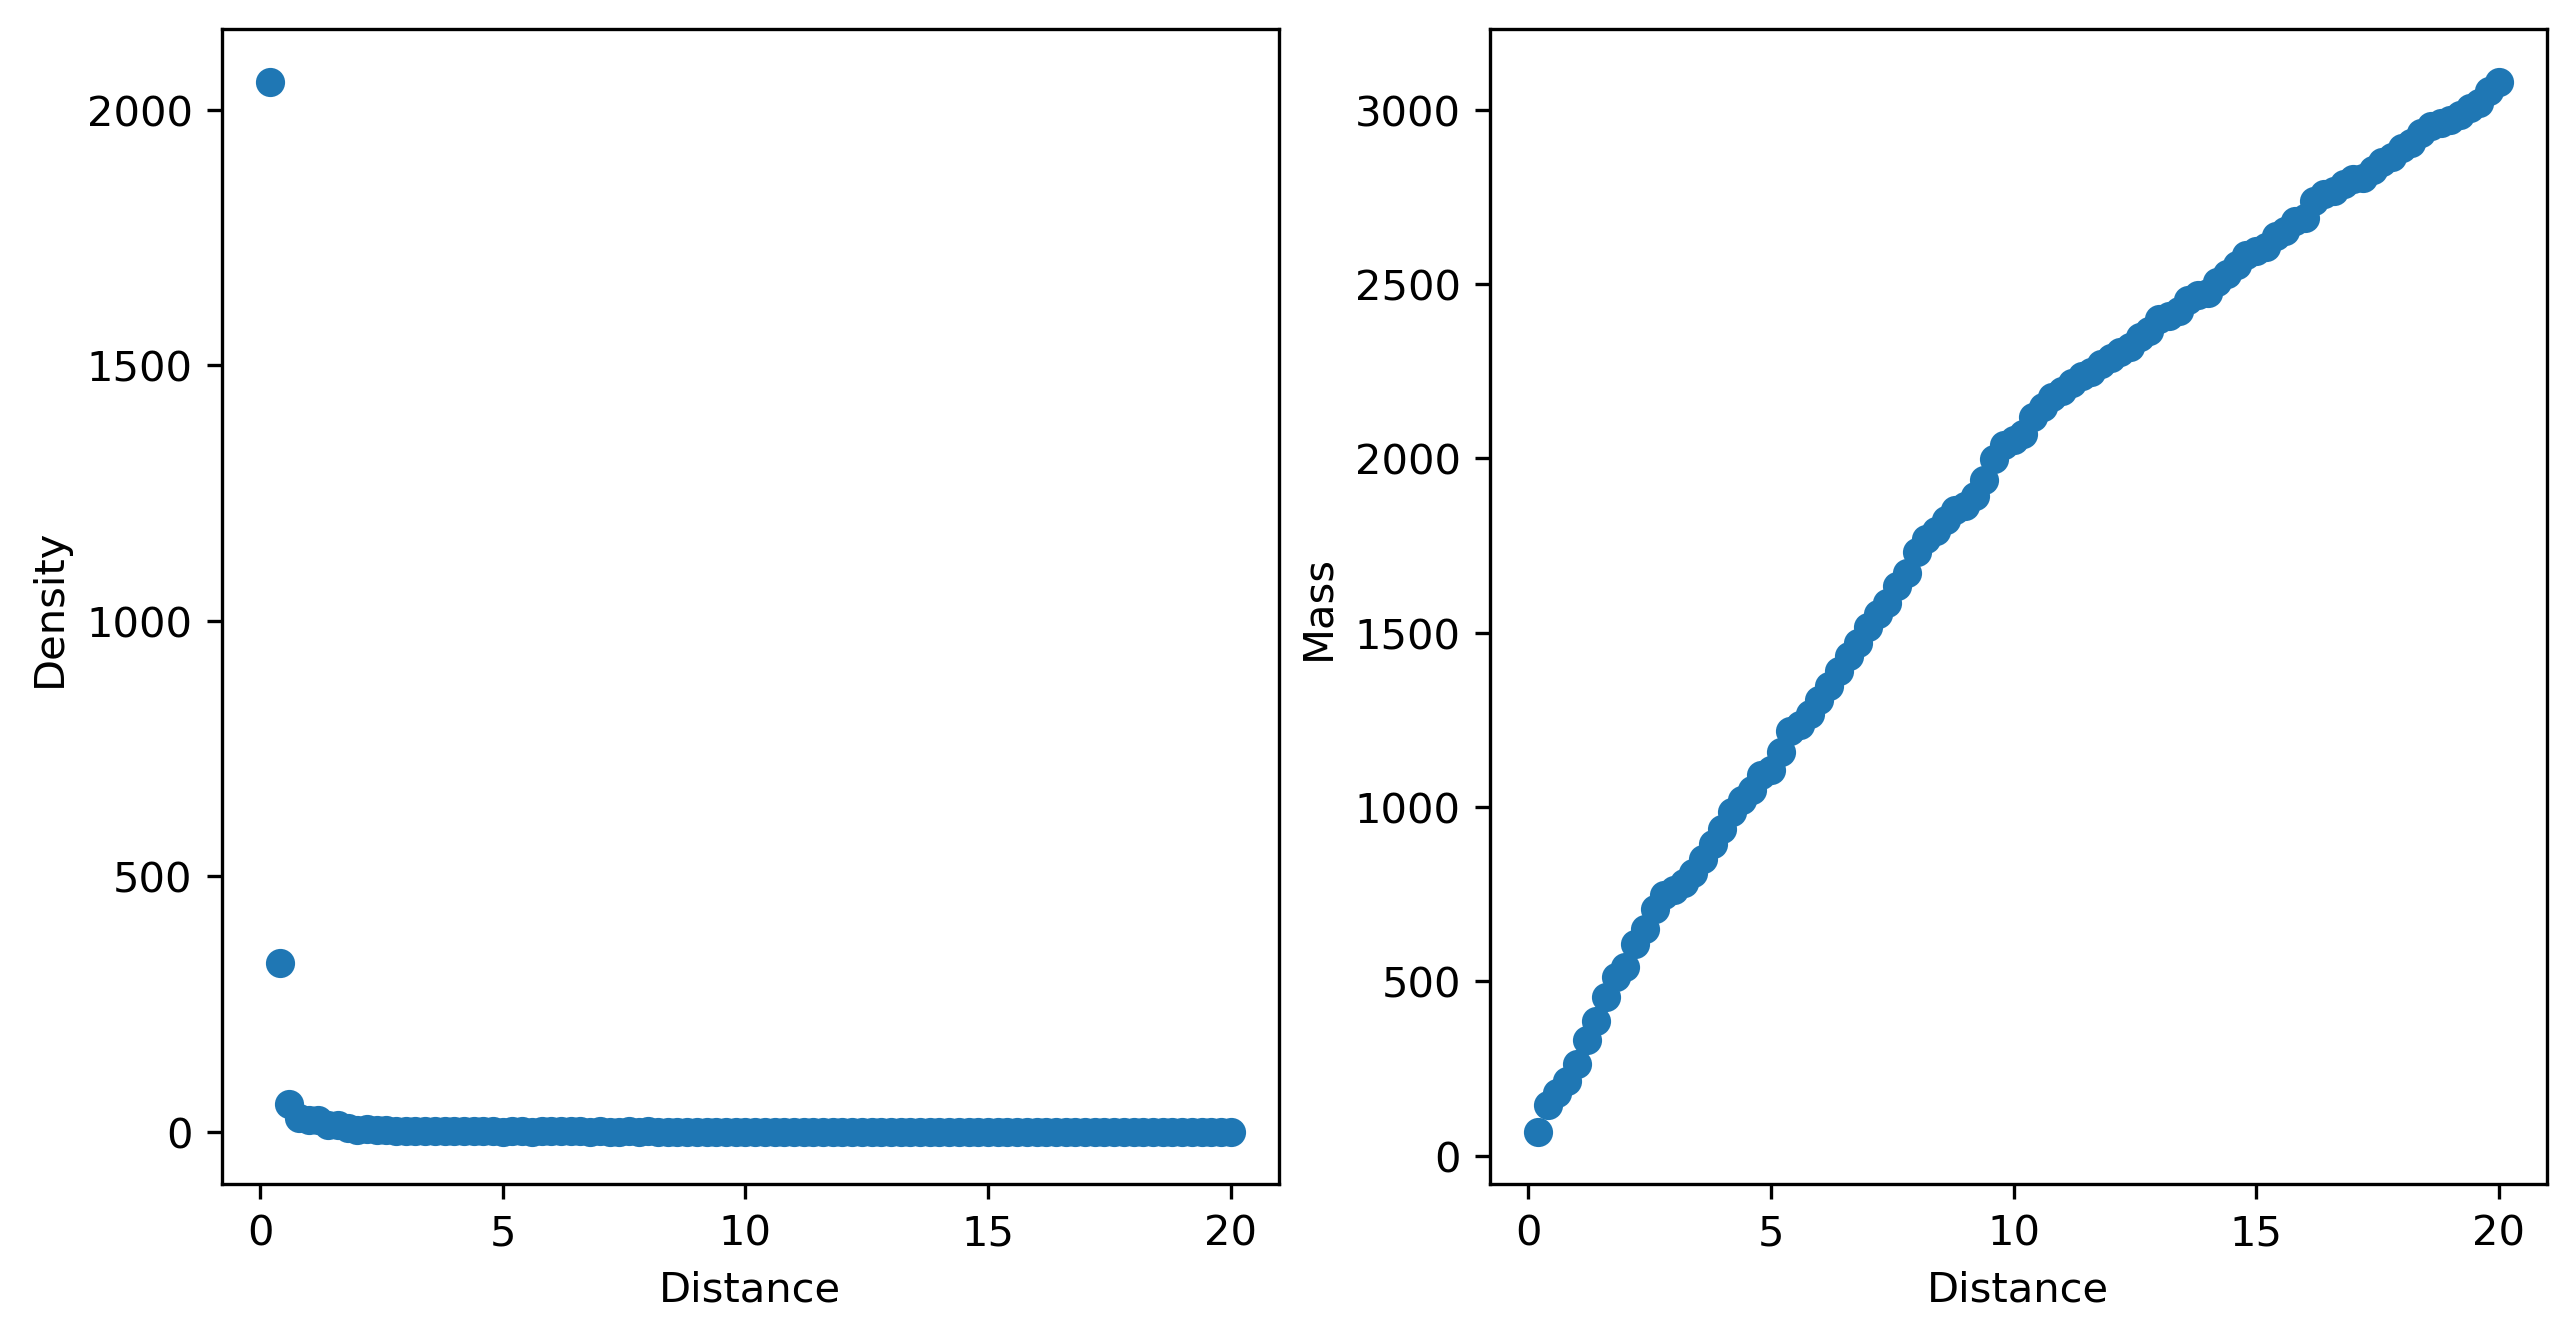

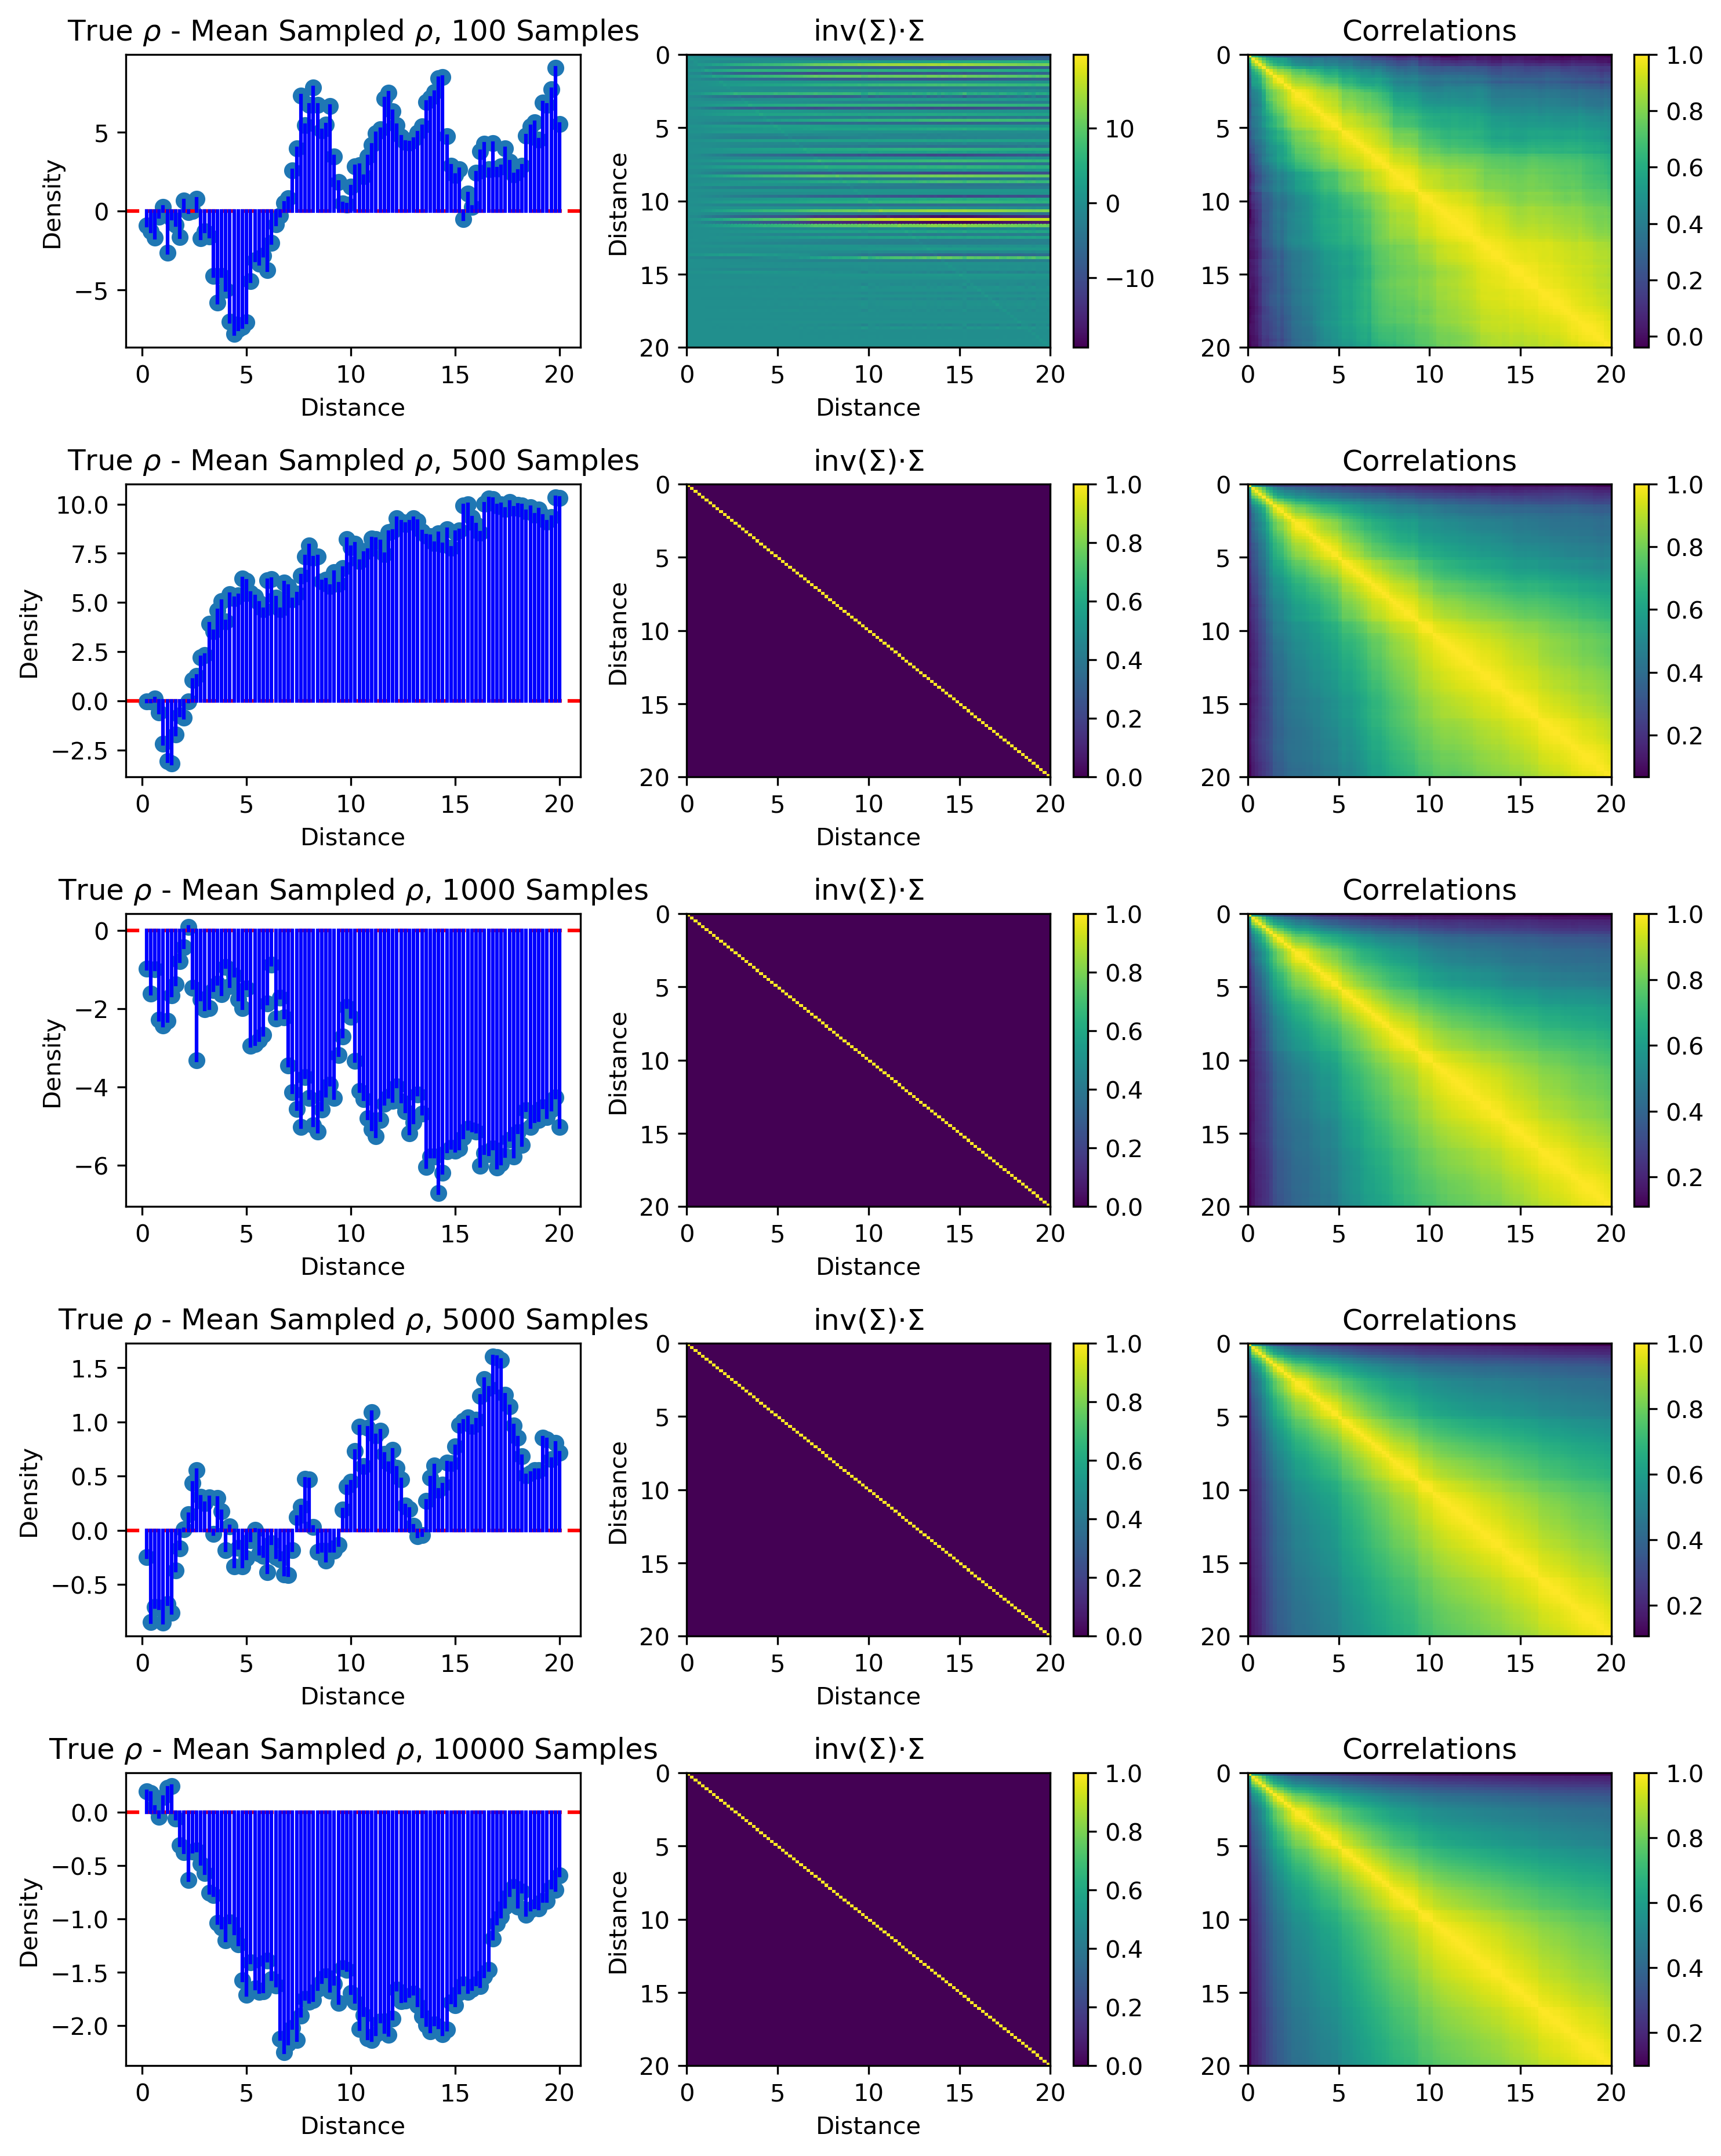

In [154]:
num_points = 1000
num_bins   = 100
# distance_bins = np.logspace(0, np.log10(20), num_bins+1, endpoint=True)
distance_bins = np.linspace(0, 20, num_bins+1, endpoint=True)
samples = [100, 500, 1000, 5000, 10000]
name = "100-bins-linear-binning"
covariance_matrix_degeneracy_demo(num_points = num_points, num_bins = num_bins, 
                                  distance_bins = distance_bins, samples = samples,
                                  name=name)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

<Figure size 1920x1440 with 0 Axes>

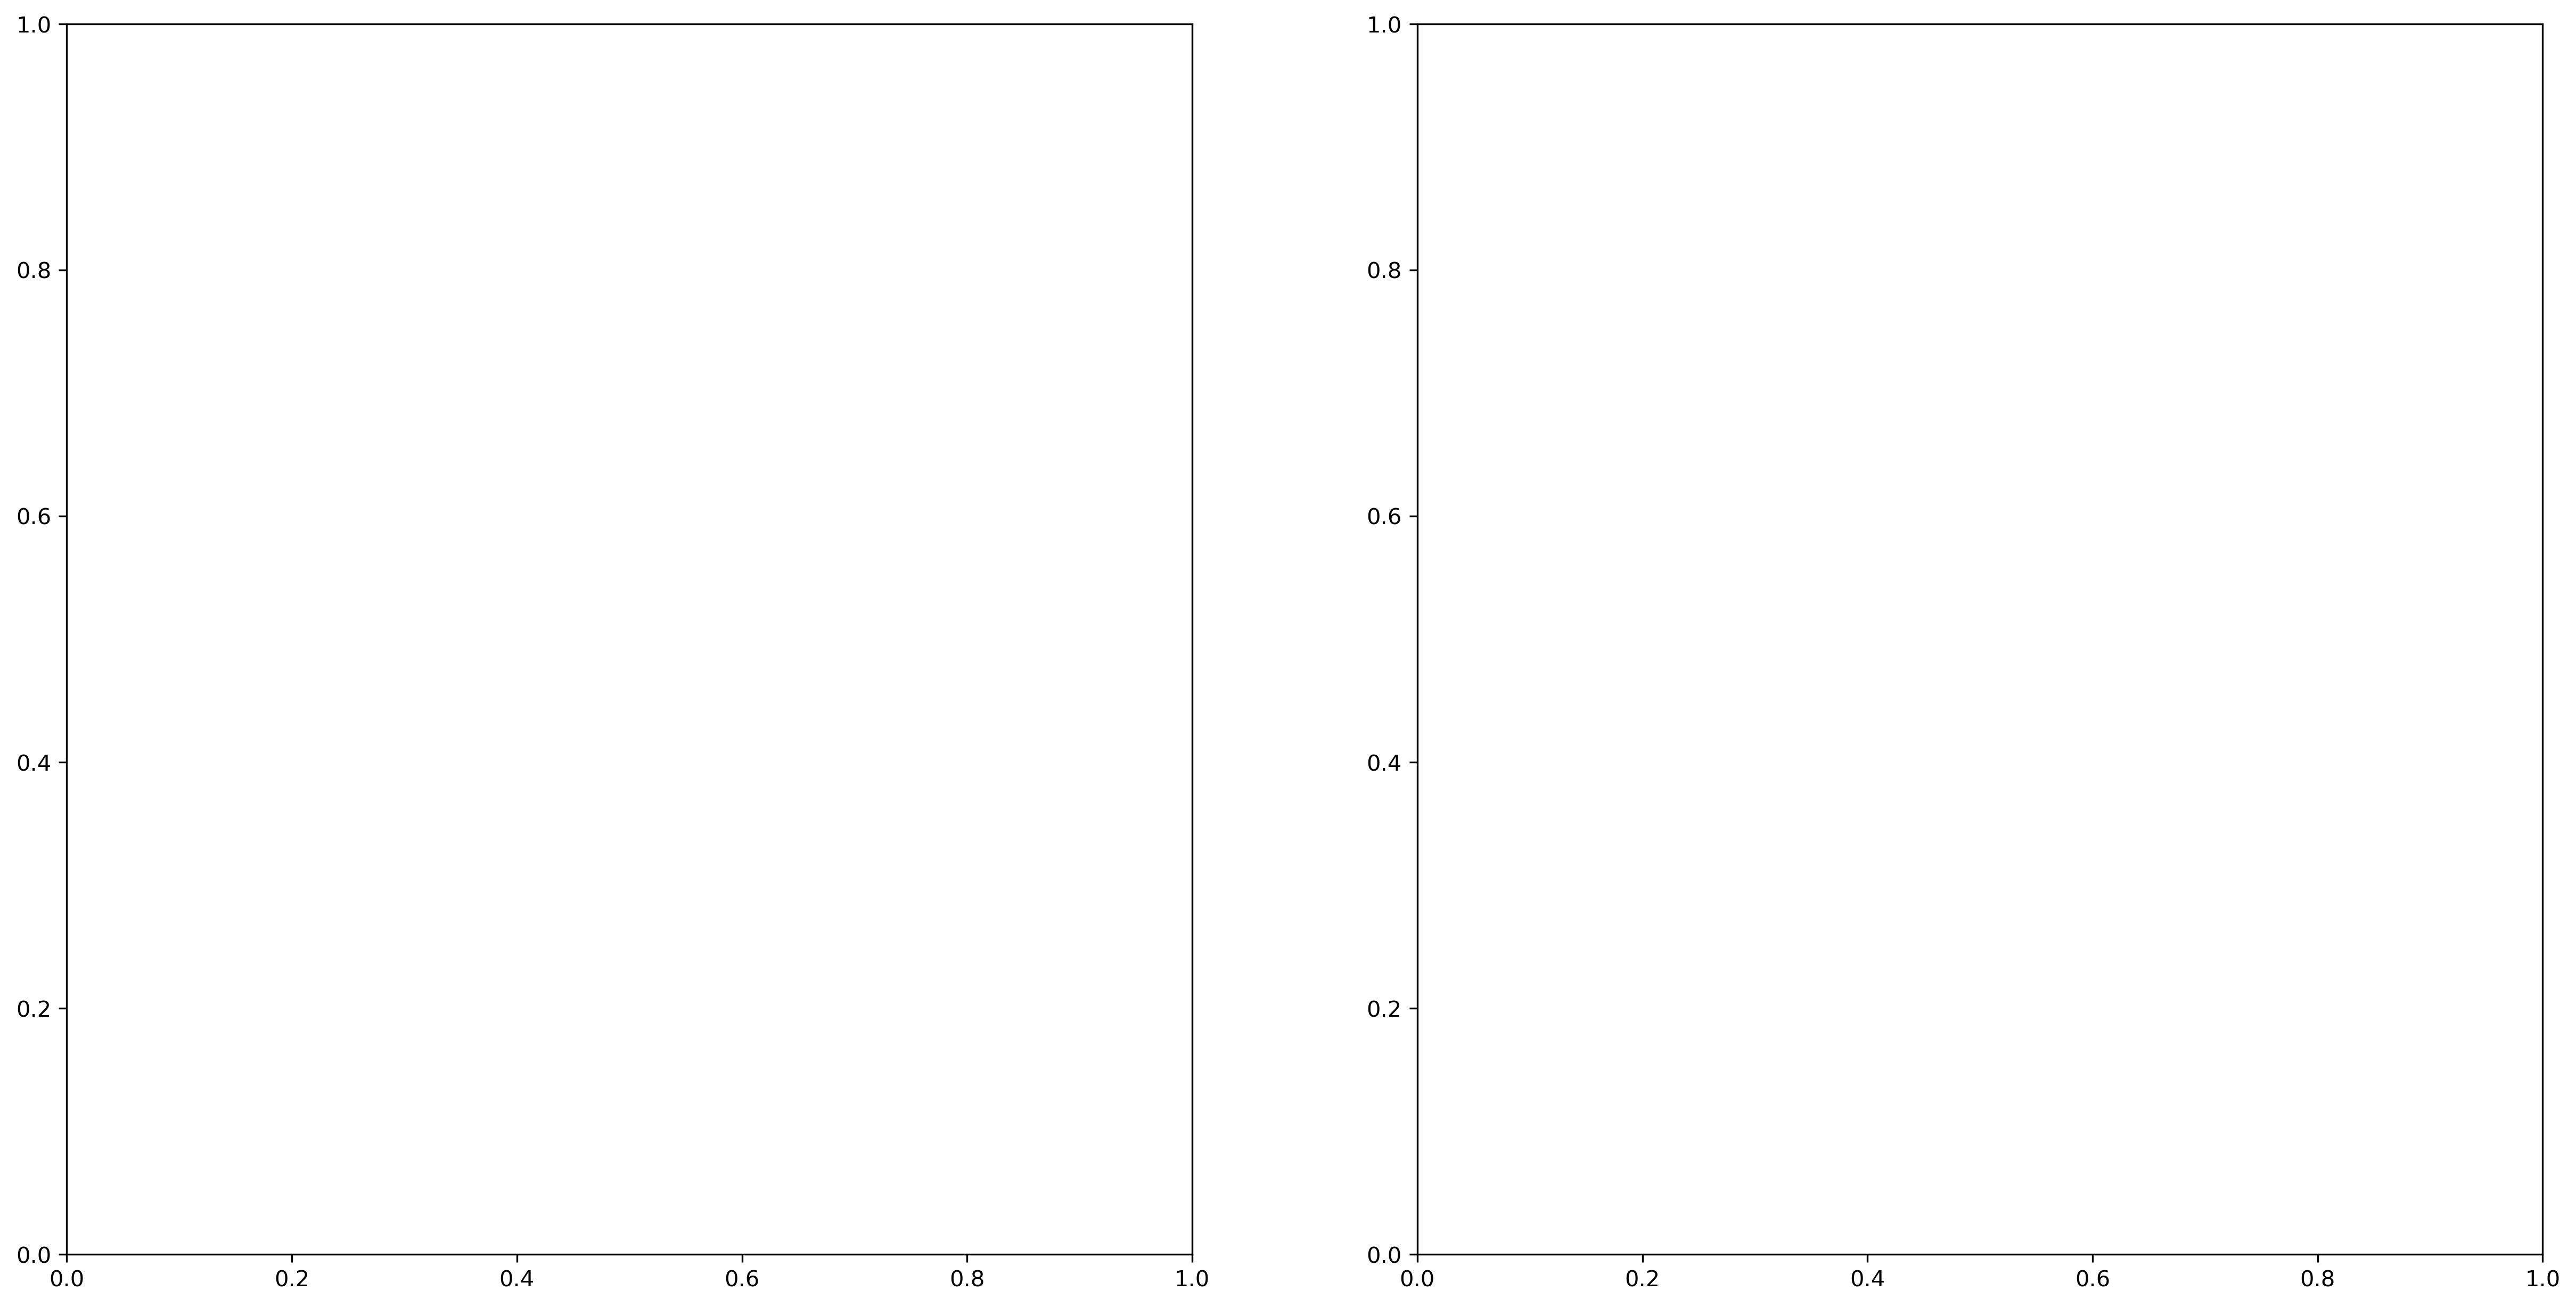

In [96]:
masses = np.random.rand(num_points) * 10
distances = np.random.exponential(scale=1, size=num_points) * 20

plt.figure(dpi=300)
fig, axes = plt.subplots(1,2,figsize=(20,10), dpi=300)
axes[0].hist(distance_bins[1:], np.histogram(masses, bins=distance_bins))
axes[0].set_xlabel("Distance")
axes[0].set_ylabel("Mass")

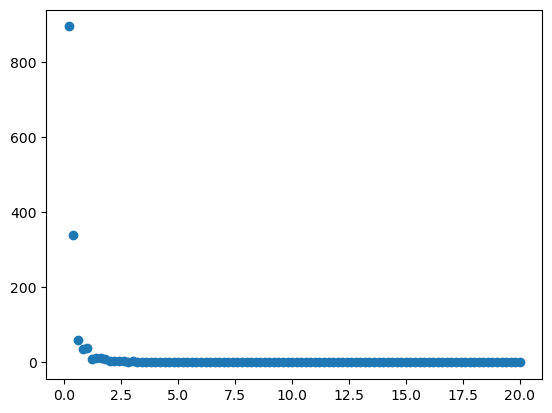

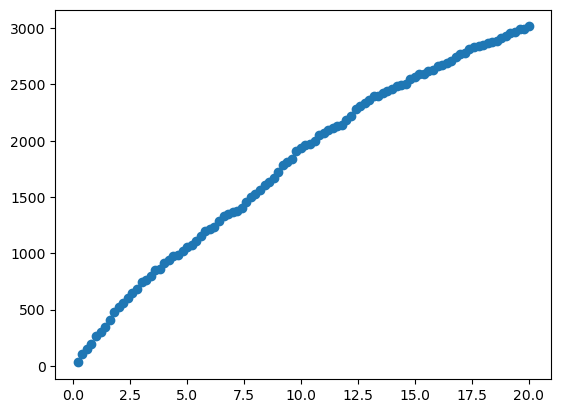

In [122]:
plt.scatter(distance_bins[1:], generate_rho_distrib_parts([masses, distances], distance_bins))
plt.show()
plt.scatter(distance_bins[1:], generate_rho_distrib_parts_cum([masses, distances]))